<a href="https://colab.research.google.com/github/Abhinavl3v3l/EVA6/blob/main/EVA6Session8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jul 10 00:54:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install albumentations==0.4.6 -q


In [3]:
import albumentations
albumentations.__version__

'0.4.6'

# Image Classification on Cifar10 dataset.

In [4]:
!git clone https://github.com/Abhinavl3v3l/EVA6.git
%cd "EVA6/s8"
!pwd

fatal: destination path 'EVA6' already exists and is not an empty directory.
/content/EVA6/s8
/content/EVA6/s8


## Necessary packages

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import numpy as np

In [6]:
from yadl.data.dataset import CIFAR10
from yadl.data.transform import albumentation_transform
from yadl.models import resnet
from yadl.utils.gradcam import gradcam, gradcam_utils
from yadl.utils.image_utilities import utils
from yadl.test import test
from yadl.train import train

## Visualize data

In [7]:
viz_data = CIFAR10.cifar10(root='./data', train=True, download=True, transform=None)
classes = viz_data.classes

Files already downloaded and verified


In [8]:
print("Classes of CIFAR10 dataset", classes)

Classes of CIFAR10 dataset ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
print(utils.dataset_calculate_mean_std())

Files already downloaded and verified
Files already downloaded and verified
([0.24697121432552785, 0.24338893940435022, 0.2615925905215076], [0.4918687788500817, 0.4826539051649305, 0.44717727749693625])


In [10]:
mean=[0.4919, 0.4827, 0.4472]
stddev=[0.2470, 0.2434, 0.2616]

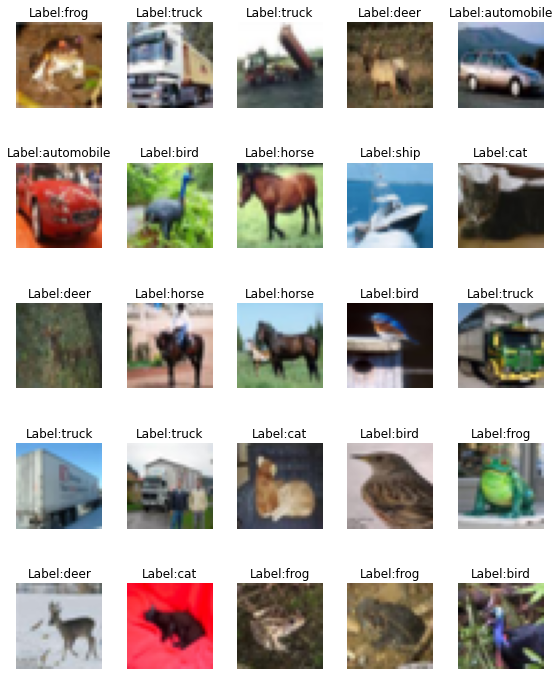

In [11]:
utils.visualize_data(viz_data,classes)

## Prepare dataset, apply transform and prepare Dataloader

In [12]:
train_transform = albumentation_transform(train=True, mean=mean, stddev=stddev)
test_transform = albumentation_transform(train=False, mean=mean, stddev=stddev)

In [13]:
train_dataset = CIFAR10.cifar10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10.cifar10(root='./data', train=False, download=True, transform=test_transform)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 133, 133])


(-0.5, 132.5, 132.5, -0.5)

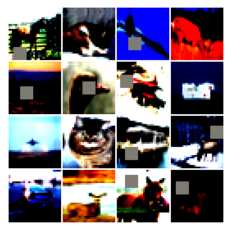

In [14]:
sample_images, sample_labels = next(iter(train_loader))
grid_image = torchvision.utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## Model

### Network model creation and summary

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = resnet.ResNet18('LayerNorm').to(device)
summary(model, input_size=(3, 32, 32))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNor

## Train model

In [16]:
EPOCHS = 40
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
l1_lambda=0
l2_lambda=0

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=l2_lambda)
# Loss condition
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, threshold=0.001, cooldown=0, min_lr=1e-4)

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, l1_lambda)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    scheduler.step(test_loss_delta)

    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 27.16  Epoch Loss: 2.2558
Test set: Epoch Accuracy: 31.08  Epoch Loss: 2.0283
Epoch: 1
Train set: Epoch Accuracy: 48.87  Epoch Loss: 1.3972
Test set: Epoch Accuracy: 52.61  Epoch Loss: 1.3446
Epoch: 2
Train set: Epoch Accuracy: 60.79  Epoch Loss: 1.0952
Test set: Epoch Accuracy: 57.3  Epoch Loss: 1.2138
Epoch: 3
Train set: Epoch Accuracy: 66.46  Epoch Loss: 0.9449
Test set: Epoch Accuracy: 67.77  Epoch Loss: 0.9019
Epoch: 4
Train set: Epoch Accuracy: 70.01  Epoch Loss: 0.8452
Test set: Epoch Accuracy: 60.96  Epoch Loss: 1.1763
Epoch: 5
Train set: Epoch Accuracy: 72.72  Epoch Loss: 0.7734
Test set: Epoch Accuracy: 71.02  Epoch Loss: 0.8496
Epoch: 6
Train set: Epoch Accuracy: 74.71  Epoch Loss: 0.713
Test set: Epoch Accuracy: 75.38  Epoch Loss: 0.6977
Epoch: 7
Train set: Epoch Accuracy: 76.86  Epoch Loss: 0.6587
Test set: Epoch Accuracy: 75.16  Epoch Loss: 0.7187
Epoch: 8
Train set: Epoch Accuracy: 78.61  Epoch Loss: 0.6065
Test set: Epoch Accuracy: 76

## Results

### Train/Test accuracy and loss versus epochs

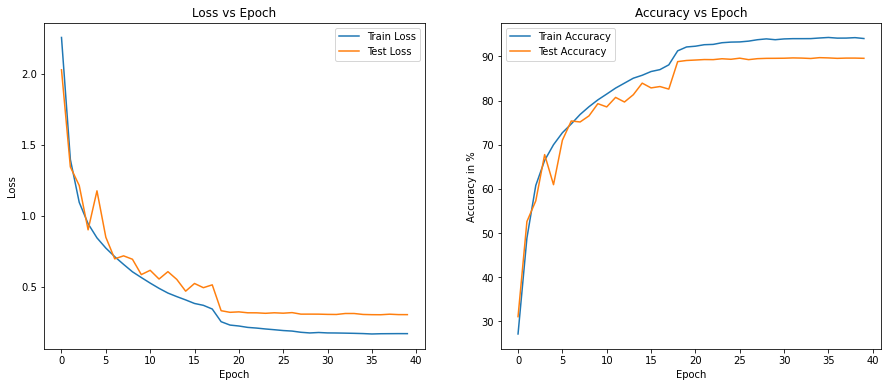

<Figure size 432x288 with 0 Axes>

In [17]:
utils.draw_loss_accuracy_graph(train_loss, test_loss, train_accuracy, test_accuracy)

### Misclassified Images

In [18]:
label_incorrect, prediction_incorrect, \
images_incorrect = utils.capture_incorrect_classified_samples(model, device, test_loader)

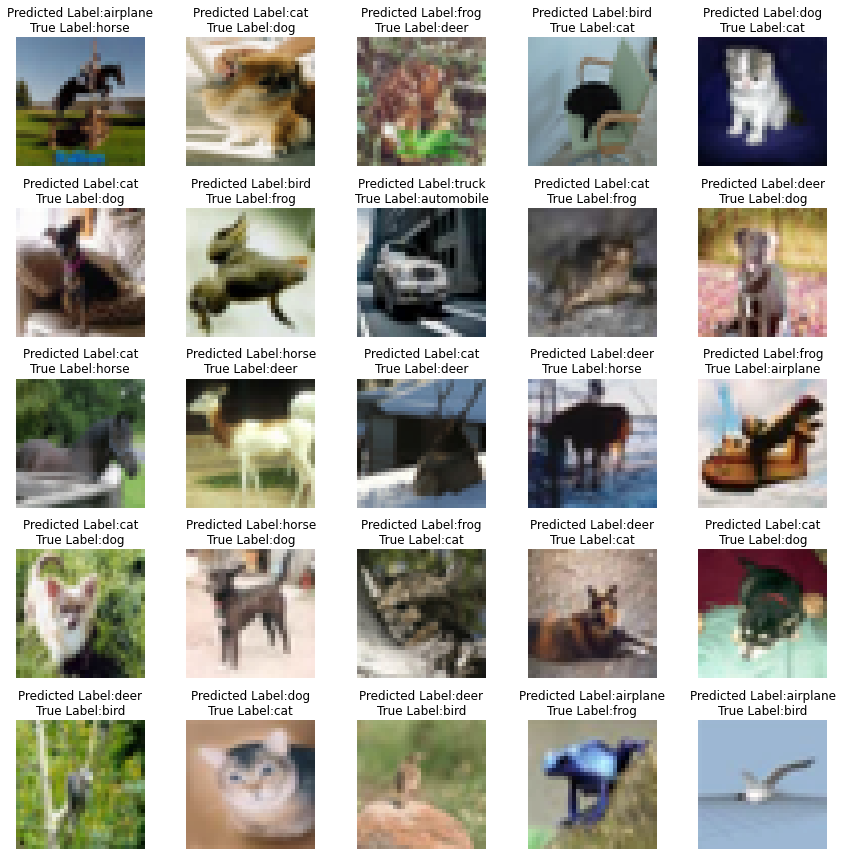

In [19]:
denormalized_images = utils.denormalize(images_incorrect, mean, stddev)
utils.show_incorrect_images(label_incorrect, prediction_incorrect, denormalized_images, classes)

## GradCAM on misclassified images

In [20]:
resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer3', input_size=(32,32))
resnet_gradcam = gradcam.GradCAM(resnet_model_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


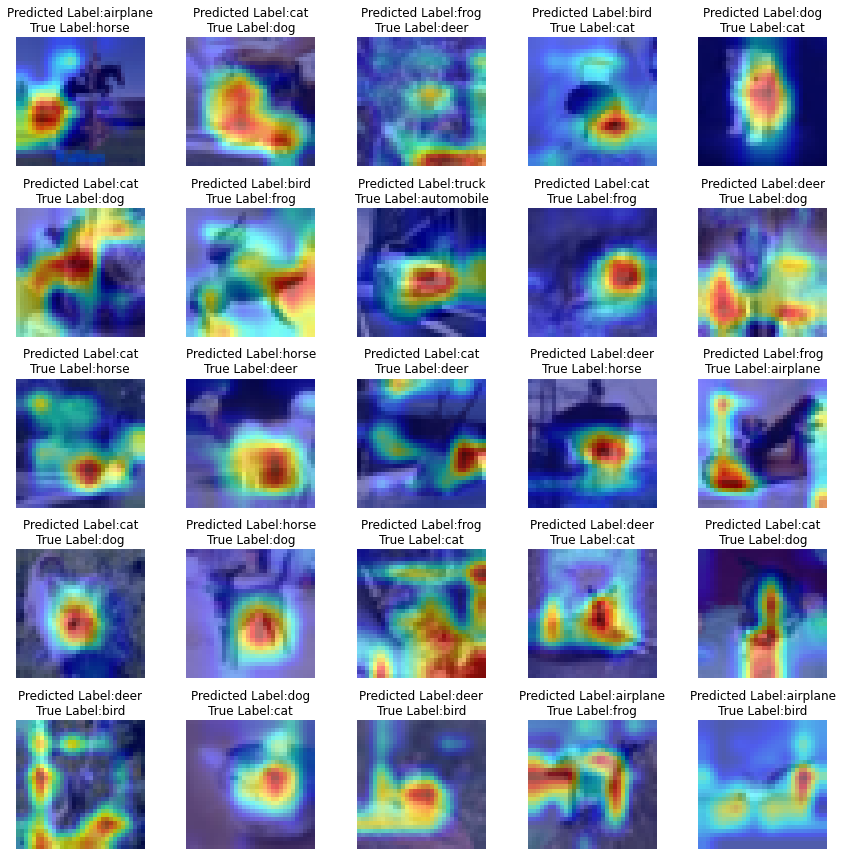

In [21]:
gradcam_utils.show_gradcam_images(resnet_gradcam, images_incorrect, label_incorrect, \
                    prediction_incorrect, classes, mean, stddev, device)